In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline, Pipeline, _name_estimators
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import seaborn as sns
import time
import matplotlib.pyplot as plt
from boruta import BorutaPy
from skmca import MCA
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

t0 = time.time()

In [31]:
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

def column_name(method, n_components):
    columns = []
    for i in range(n_components):
        name = method + str(i)
        columns.append(name)
    return columns

def generate_decomp(dtrain, dtest, n_components=5, random_state=420):
    '''
    Generate PCA, MCA values without 'ID' feature
    '''
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(dtrain[dtrain.columns[1:]])
    test_pca = pca.transform(dtest[dtest.columns[1:]])
    train_pca = pd.DataFrame(train_pca)
    test_pca = pd.DataFrame(test_pca)
    train_pca.columns = column_name('pca', n_components)
    test_pca.columns = column_name('pca', n_components)
    
    mca = MCA(n_components=n_components)
    binary_df = all_features_df[all_features_df.columns[1:]].apply(lambda x: x.astype('category'))
    binary_df_mca = pd.DataFrame(mca.fit_transform(binary_df))
    train_mca = binary_df_mca[:len(train)]
    test_mca  = binary_df_mca[len(train):]
    test_mca.index = range(test_mca.shape[0])
    train_mca.columns = column_name('mca', n_components)
    test_mca.columns  = column_name('mca', n_components)
    
    return train_pca, test_pca, train_mca, test_mca

def load_data(drop=False, outlier=False, encode=False) : 
    train = pd.read_csv("./Data/train.csv")
    test = pd.read_csv("./Data/test.csv")
    if outlier : 
        train = train[train['y'] < 200]
        train.index = range(train.shape[0])
    if encode :
        for c in train.columns:
            if train[c].dtype == 'object' :
                lbl = LabelEncoder()
                lbl.fit(list(train[c].values) + list(test[c].values))
                train[c] = lbl.transform(list(train[c].values))
                test[c]  = lbl.transform(list(test[c].values))
    if drop : 
        train.drop(['y'], axis=1, inplace=True)
    return train, test

In [32]:
# Load data
train, test = load_data()

target = train['y'].values
id_test = test['ID']

num_train = len(train)
df_all = pd.concat([train, test], axis=0, ignore_index=True)

In [33]:
X0Mean = pd.DataFrame({'X0' : train.groupby(['X0']).mean()['y'].index,
             'X0_mean' : train.groupby(['X0'], as_index=False).mean()['y']})
mean_joined = df_all.join(X0Mean.set_index('X0'), on='X0')
mean_joined['X0_mean'] = mean_joined['X0_mean'].fillna(np.nanmean(mean_joined['X0_mean']))

train_X0Mean = mean_joined[mean_joined.columns[-1:]][:num_train]
test_X0Mean = mean_joined[mean_joined.columns[-1:]][num_train:]
test_X0Mean.index = range(test_X0Mean.shape[0])

In [34]:
df_all.drop(['y'], axis=1, inplace=True)

In [35]:
'''
## FIRST ##
Every Features + PCA/MCA + (Log Transformation)
'''

all_features_df = pd.get_dummies(df_all)
train = all_features_df[:num_train]
test  = all_features_df[num_train:]
test.index = range(test.shape[0])

train_pca, test_pca, train_mca, test_mca = generate_decomp(train, test)

dtrain = pd.concat([train, train_pca, train_mca], axis=1)
dtest = pd.concat([test, test_pca, test_mca], axis=1)

In [36]:
# xgboost = xgb.sklearn.XGBRegressor(objective        = 'reg:linear', 
#                                    min_child_weight = 0.5,
#                                    max_depth        = 4,
#                                    learning_rate    = 0.01,
#                                    subsample        = 0.9,
#                                    n_estimators     = 550,
#                                    seed             = 0,
#                                    base_score       = np.mean(target),
#                                    nthread          = -1)

# xgboost_log = xgb.sklearn.XGBRegressor(objective     = 'reg:linear',
#                                        max_depth     = 4,
#                                        learning_rate = 0.01,
#                                        n_estimators  = 760,
#                                        seed          = 0,
#                                        base_score    = np.mean(np.log1p(target)),
#                                        nthread       = -1)

xgboost = xgb.sklearn.XGBRegressor(objective        = 'reg:linear',
                                   max_depth        = 3,
                                   learning_rate    = 0.01,
                                   subsample        = 0.9,
                                   n_estimators     = 400,
                                   seed             = 0,
                                   base_score       = np.mean(target),
                                   nthread          = -1)

xgboost_log = xgb.sklearn.XGBRegressor(objective     = 'reg:linear',
                                       max_depth     = 3,
                                       learning_rate = 0.01,
                                       n_estimators  = 410,
                                       seed          = 0,
                                       subsample     = 0.9,
                                       base_score    = np.mean(np.log1p(target)),
                                       nthread       = -1)

rf = RandomForestRegressor(n_estimators = 800,
                           max_depth    = 4,
                           max_features = 'auto',
                           n_jobs       = -1)

alphas_ridge = np.exp(np.linspace(3, -3, 300))
ridge = RidgeCV(alphas    = alphas_ridge,
                scoring   = 'r2',
                normalize = False)

In [37]:
stack_train = pd.DataFrame(index=np.arange(len(train)))
stack_test  = pd.DataFrame(index=np.arange(len(test)))

In [38]:
models = [xgboost, rf, ridge]
models_description = ['XGB1', 'RF1', 'Ridge1']

In [39]:
dtest.shape

(4209, 590)

In [40]:
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

for model in models :
        name = models_description[models.index(model)]
        stack_train[name] = 0  # Initialize
        
        regr = clone(model)
        regr.fit(dtrain, target)
        pred = regr.predict(dtest)
        stack_test[name] = pred
        
        for train_idx, holdout_idx in kfold.split(dtrain, target) :
            regr = clone(model)
            regr.fit(dtrain.iloc[train_idx], target[train_idx])
            tmp = regr.predict(dtrain.iloc[holdout_idx])
            stack_train[name][holdout_idx] = tmp

In [41]:
models = [xgboost_log, rf, ridge]
models_description = ['XGB2', 'RF2', 'Ridge2']

for model in models :
        name = models_description[models.index(model)]
        stack_train[name] = 0  # Initialize
        
        regr = clone(model)
        regr.fit(dtrain, np.log1p(target))
        pred = regr.predict(dtest)
        stack_test[name] = np.expm1(pred)
        
        for train_idx, holdout_idx in kfold.split(dtrain, target) :
            regr = clone(model)
            regr.fit(dtrain.iloc[train_idx], np.log1p(target[train_idx]))
            tmp = regr.predict(dtrain.iloc[holdout_idx])
            stack_train[name][holdout_idx] = np.expm1(tmp)

In [42]:
#############################################
train, test = load_data(drop=True)

# Binary features에 대해서만 Boruta analysis
# ID, X0, X1는 무조건 포함
fixed_column = pd.Index(['ID', 'X0', 'X2'])
binary_train = train[train.columns[9:]]

rf_boruta = RandomForestRegressor(n_jobs    = -1,
                                  max_depth = 4)

feature_selector = BorutaPy(rf_boruta,
                            n_estimators ='auto',
                            random_state = 0)
feature_selector.fit(binary_train.values, target)
                     
selected_features = binary_train.columns[feature_selector.support_]
columns = fixed_column.append(selected_features)

In [43]:
train = train[columns]
test  = test[columns]
df_all = pd.concat([train, test], axis=0, ignore_index=True)

#df_all['group1'] = df_all['X0'].map(lambda s : 1 if s in group1 else 0)
#df_all['group2'] = df_all['X0'].map(lambda s : 1 if s in group2 else 0)
#df_all['group3'] = df_all['X0'].map(lambda s : 1 if s in group3 else 0)
#df_all['group4'] = df_all['X0'].map(lambda s : 1 if s in group4 else 0)

all_features_df = pd.get_dummies(df_all)
train = all_features_df[:num_train]
test  = all_features_df[num_train:]
test.index = range(test.shape[0])

In [44]:
dtrain = train.copy()
dtest  = test.copy()

dtrain = pd.concat([dtrain, train_X0Mean], axis = 1)
dtest  = pd.concat([dtest, test_X0Mean], axis = 1)

In [45]:
models = [xgboost, rf, ridge]
models_description = ['XGB3', 'RF3', 'Ridge3']

for model in models :
        name = models_description[models.index(model)]
        stack_train[name] = 0  # Initialize
        
        regr = clone(model)
        regr.fit(dtrain, target)
        pred = regr.predict(dtest)
        stack_test[name] = pred
        
        for train_idx, holdout_idx in kfold.split(dtrain, target) :
            regr = clone(model)
            regr.fit(dtrain.iloc[train_idx], target[train_idx])
            tmp = regr.predict(dtrain.iloc[holdout_idx])
            stack_train[name][holdout_idx] = tmp

In [46]:
models = [xgboost_log, rf, ridge]
models_description = ['XGB4', 'RF4', 'Ridge4']

for model in models :
        name = models_description[models.index(model)]
        stack_train[name] = 0  # Initialize
        
        regr = clone(model)
        regr.fit(dtrain, np.log1p(target))
        pred = regr.predict(dtest)
        stack_test[name] = np.expm1(pred)
        
        for train_idx, holdout_idx in kfold.split(dtrain, target) :
            regr = clone(model)
            regr.fit(dtrain.iloc[train_idx], np.log1p(target[train_idx]))
            tmp = regr.predict(dtrain.iloc[holdout_idx])
            stack_train[name][holdout_idx] = np.expm1(tmp)

In [47]:
train_pca, test_pca, train_mca, test_mca = generate_decomp(train, test)

dtrain = pd.concat([train, train_pca, train_mca, train_X0Mean], axis=1)
dtest = pd.concat([test, test_pca, test_mca, test_X0Mean], axis=1)

In [48]:
models = [xgboost, rf, ridge]
models_description = ['XGB5', 'RF5', 'Ridge5']

for model in models :
        name = models_description[models.index(model)]
        stack_train[name] = 0  # Initialize
        
        regr = clone(model)
        regr.fit(dtrain, target)
        pred = regr.predict(dtest)
        stack_test[name] = pred
        
        for train_idx, holdout_idx in kfold.split(dtrain, target) :
            regr = clone(model)
            regr.fit(dtrain.iloc[train_idx], target[train_idx])
            tmp = regr.predict(dtrain.iloc[holdout_idx])
            stack_train[name][holdout_idx] = tmp

In [49]:
models = [xgboost_log, rf, ridge]
models_description = ['XGB6', 'RF6', 'Ridge6']

for model in models :
        name = models_description[models.index(model)]
        stack_train[name] = 0  # Initialize
        
        regr = clone(model)
        regr.fit(dtrain, np.log1p(target))
        pred = regr.predict(dtest)
        stack_test[name] = np.expm1(pred)
        
        for train_idx, holdout_idx in kfold.split(dtrain, target) :
            regr = clone(model)
            regr.fit(dtrain.iloc[train_idx], np.log1p(target[train_idx]))
            tmp = regr.predict(dtrain.iloc[holdout_idx])
            stack_train[name][holdout_idx] = np.expm1(tmp)

In [50]:
######################################
# Second-level regressor!
# XGBoost

params = {'objective'        : 'reg:linear',
          'eta'              : 0.005,
          'max_depth'        : 3,
          'n_jobs'           : -1,
          'subsample'        : 0.9,
          'base_score'       : np.mean(target),
          #'lambda'           : 1.5,
          #'min_child_weight' : 2,
          #'alpha'     : 0.1,
          #'gamma'     : 1
}

xtrain_stack = xgb.DMatrix(stack_train, target, feature_names = stack_train.columns)
xtest_stack  = xgb.DMatrix(stack_test, feature_names = stack_test.columns)

xgb_stack_cv = xgb.cv(params, xtrain_stack,
                      nfold                 = 5,
                      num_boost_round       = 1000,
                      early_stopping_rounds = 40,
                      verbose_eval          = 100,
                      stratified            = True,
                      feval                 = xgb_r2_score,
                      maximize              = True
                     )

print("# Iteration: " + str(len(xgb_stack_cv)) + " / R2 Score: " + str(xgb_stack_cv['test-r2-mean'][len(xgb_stack_cv) - 1]))

[0]	train-r2:0.0057076+0.000160303	test-r2:0.0052756+0.00117618
[100]	train-r2:0.368609+0.0118022	test-r2:0.365479+0.0425336
[200]	train-r2:0.505962+0.0157144	test-r2:0.498982+0.0579439
[300]	train-r2:0.560124+0.017107	test-r2:0.547971+0.0629586
[400]	train-r2:0.583927+0.01734	test-r2:0.565876+0.0642772
[500]	train-r2:0.596604+0.0170357	test-r2:0.572422+0.0643161
[600]	train-r2:0.604941+0.0165091	test-r2:0.574674+0.0640126
[700]	train-r2:0.611908+0.0158446	test-r2:0.575088+0.0635029
# Iteration: 761 / R2 Score: 0.5752024


In [51]:
nrounds = len(xgb_stack_cv)
xgb_stack = xgb.train(params, xtrain_stack,
                      num_boost_round = nrounds)
benz_pred = xgb_stack.predict(xtest_stack)

pred_df = pd.DataFrame()
pred_df['ID'] = id_test; pred_df['y'] = benz_pred
pred_df.to_csv("./Submission/stacked_xgb_without_outlier.csv", index=False)

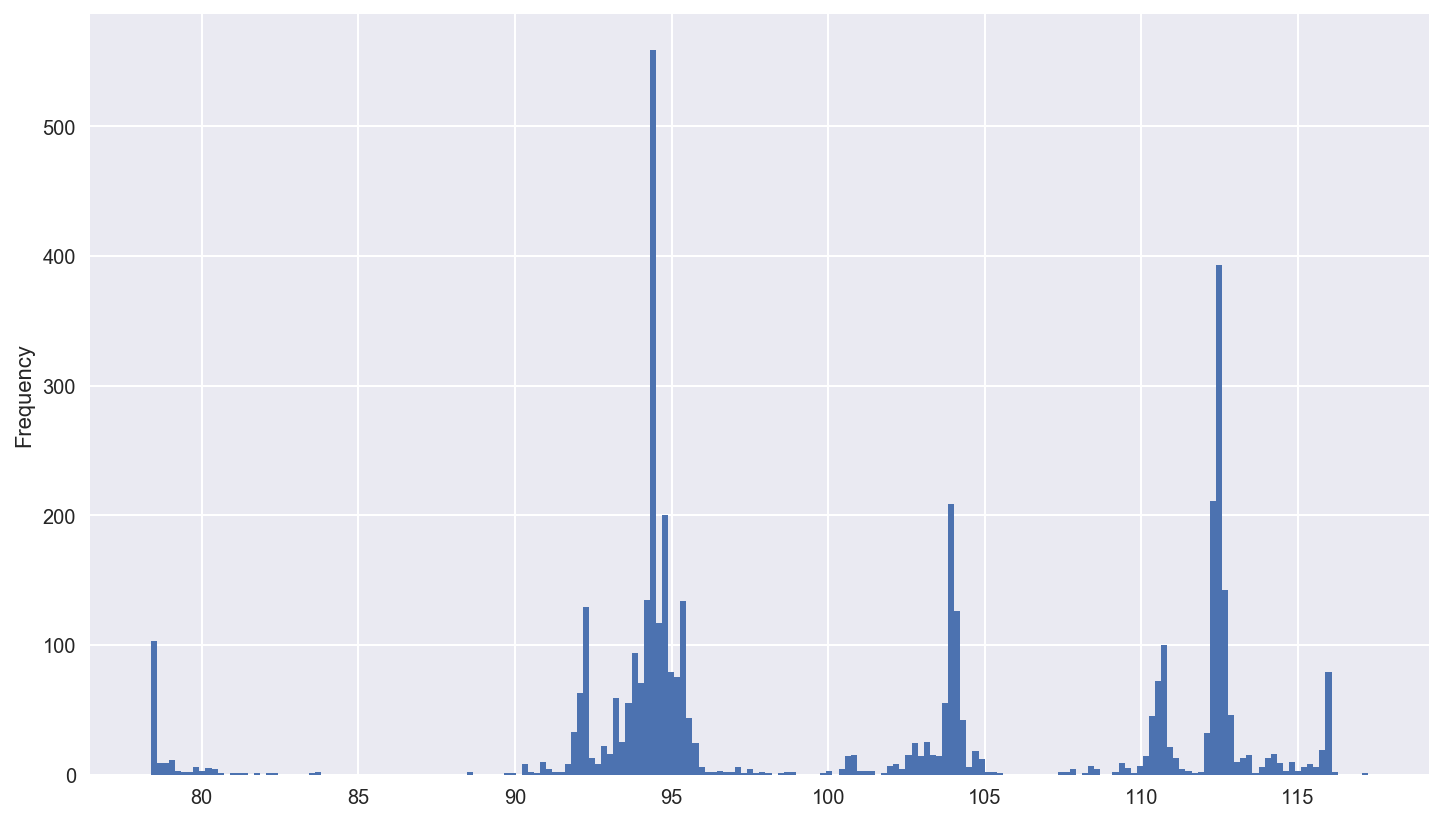

In [52]:
plt.figure(figsize=(12,7))
pred_df['y'].plot(kind = "hist", bins = 200)

In [53]:
alphas = np.exp(np.linspace(-5, -2.5, 200))
l1_ratioes = np.linspace(0, 1, 10)
en_stack = ElasticNetCV(alphas       = alphas,
                        #cv           = 5,
                        l1_ratio     = l1_ratioes,
                        n_jobs       = -1,
                        positive     = False,
                        normalize    = False,
                        random_state = 0)
en_stack.fit(stack_train, np.log1p(target))
print("Alpha:", en_stack.alpha_, ", L1 Ratio:", en_stack.l1_ratio_)

Alpha: 0.01216067689 , L1 Ratio: 0.555555555556


In [54]:
en_pred = np.expm1(en_stack.predict(stack_test))
pred_df2 = pd.DataFrame()
pred_df2['ID'] = id_test; pred_df2['y'] = en_pred
pred_df2.to_csv("./Submission/stacked_en_without_outlier.csv", index=False)

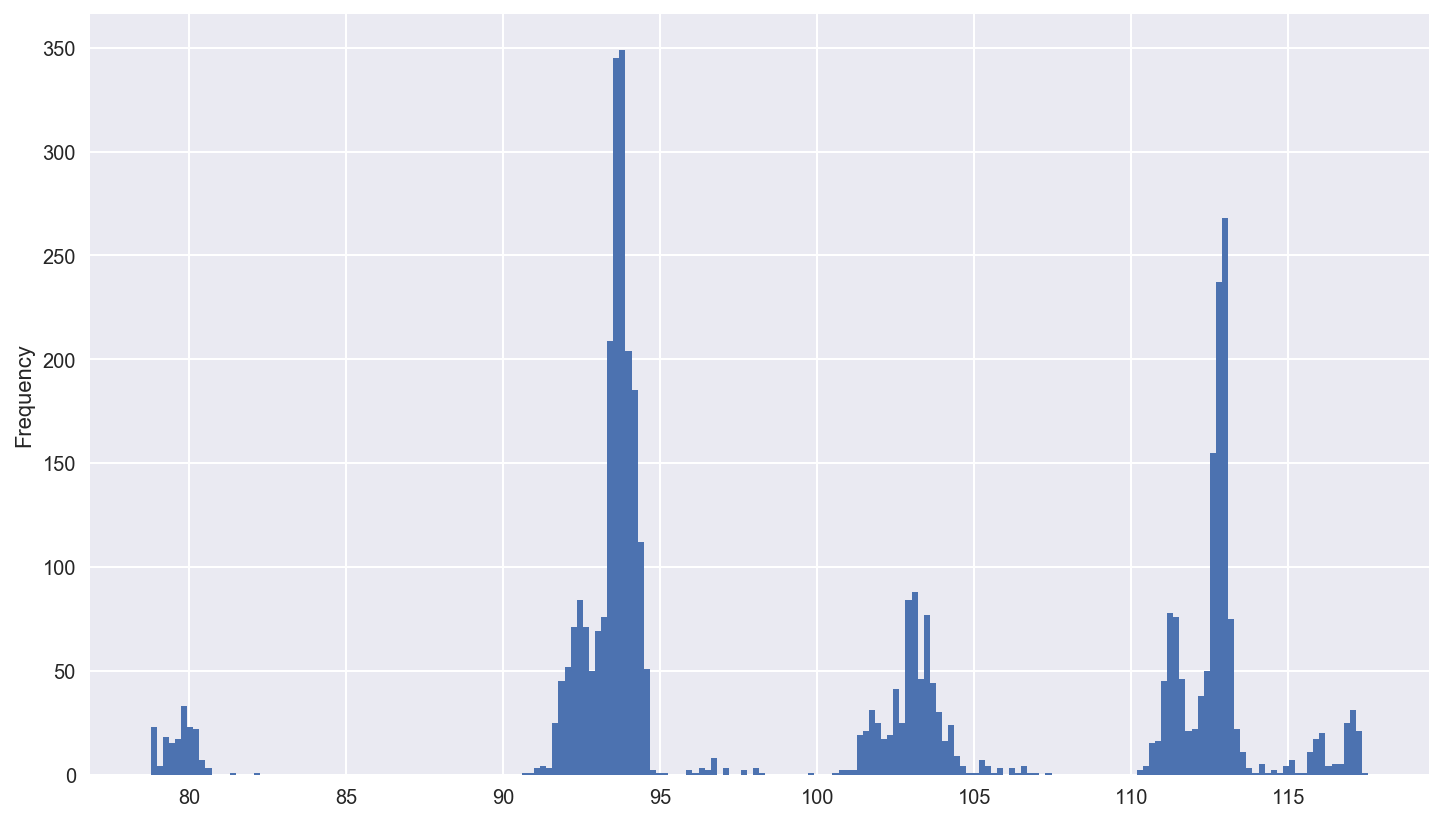

In [55]:
plt.figure(figsize=(12,7))
pred_df2['y'].plot(kind = "hist", bins = 200)

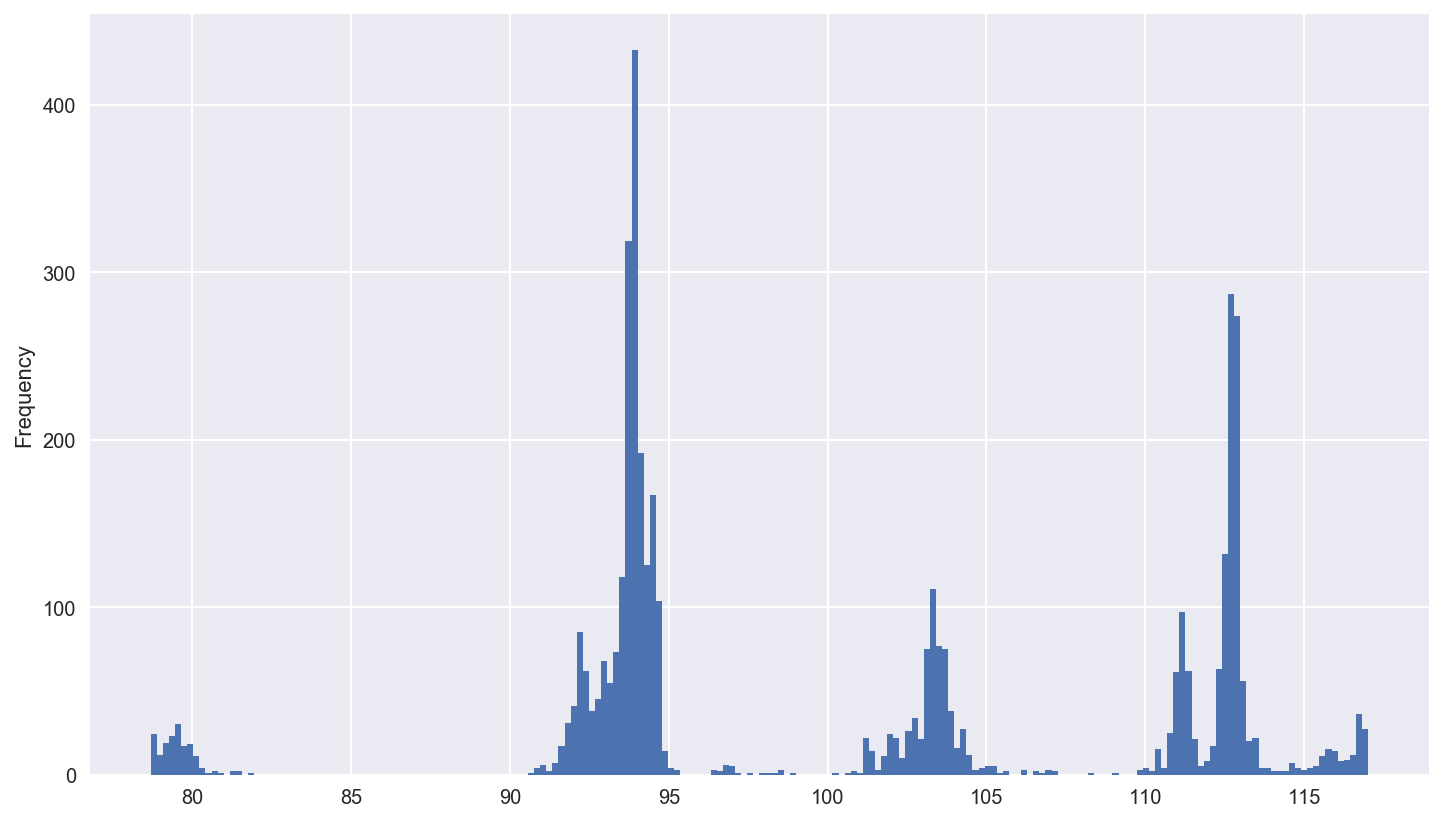

In [56]:
def weighted_ave(weight = 0.25) :
    weighted_df = pd.DataFrame()
    weighted_df['ID'] = id_test
    weighted = weight * pred_df['y'] + (1 - weight) * pred_df2['y']
    weighted_df['y'] = weighted
    return weighted_df

weighted_df = weighted_ave()
plt.figure(figsize=(12,7))
weighted_df['y'].plot(kind = "hist", bins = 200)
weighted_df.to_csv("./Submission/stacked_average.csv", index=False)

In [57]:
weighted_df.head(10)

,ID,y
0,1,81.409225
1,2,97.613773
2,3,81.375041
3,4,79.914037
4,5,112.847521
5,8,96.410690
6,10,113.629738
7,11,96.368432
8,12,116.938243
9,14,96.437446


In [58]:
t1 = time.time()
print("Runtime:", np.round(t1-t0), "Seconds")

Runtime: 601.0 Seconds
